In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
import warnings
from collections import defaultdict
import shap


%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8
import seaborn as sns

# Import internal classes
from distributions import DistributionShift

In [3]:
from xgboost import XGBRegressor
from tabulate import tabulate

In [4]:
dataset_classes = [
    #Airfoil,
    #Concrete,
    #FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    PowerPlant,
    #Protein,
    #Servo,
]

In [5]:
for dataset in dataset_classes:
    print(dataset().shape)

(9568, 5)


(4775, 4)


  0%|          | 0/4 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


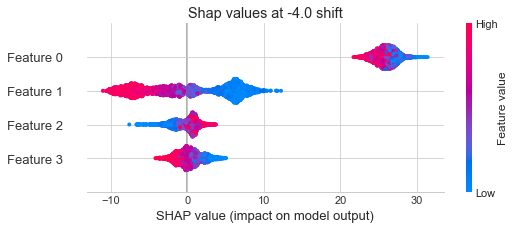

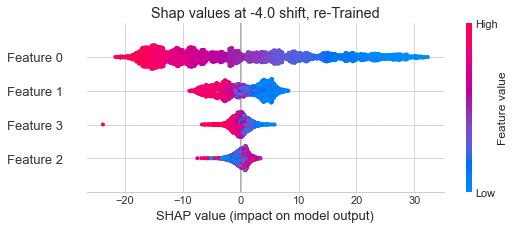

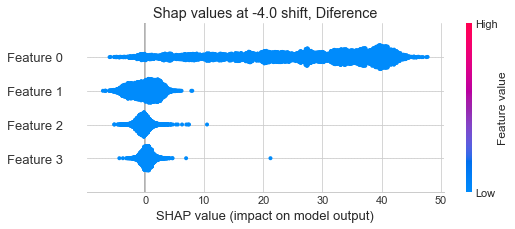

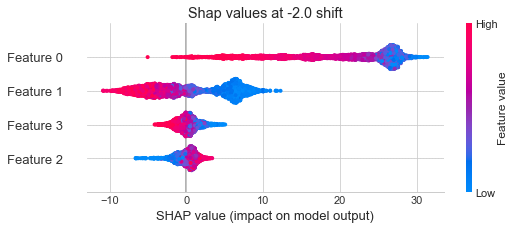

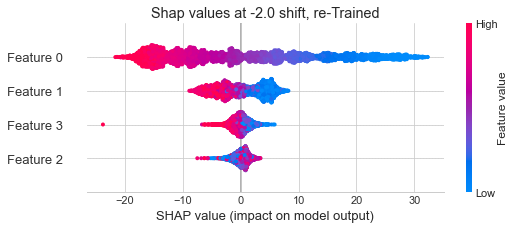

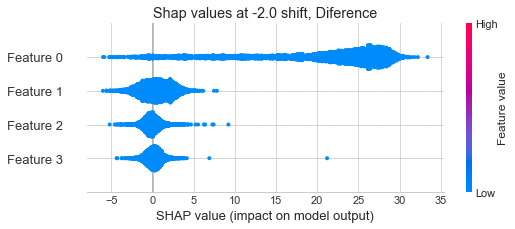

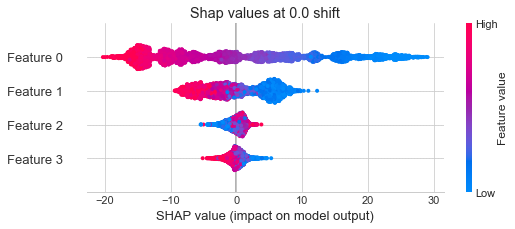

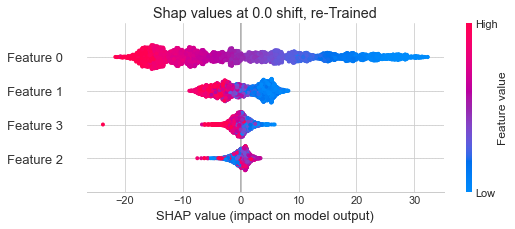

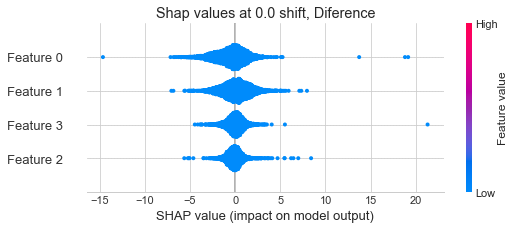

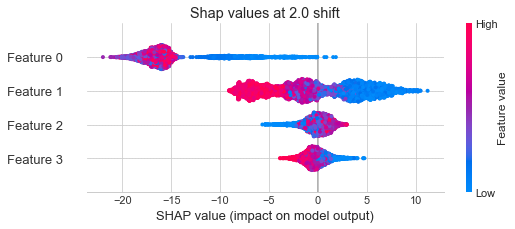

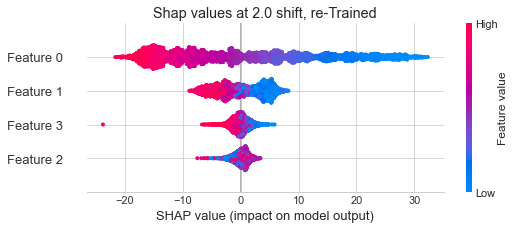

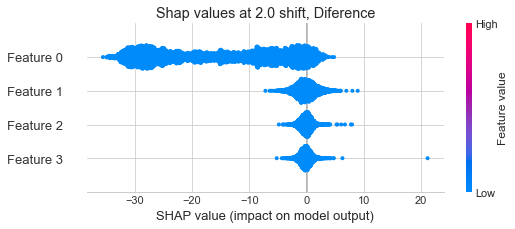

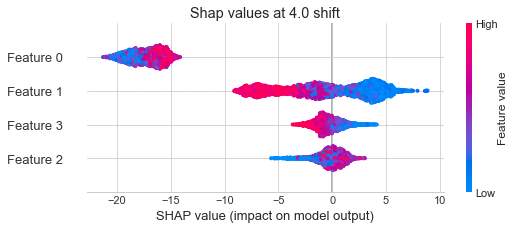

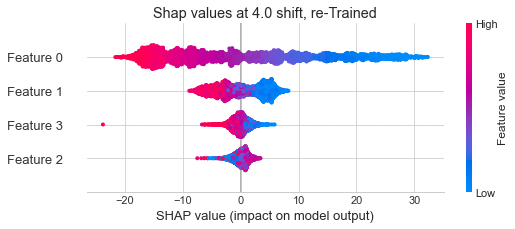

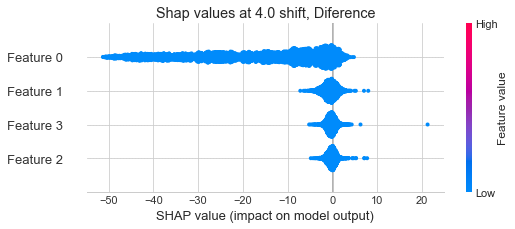

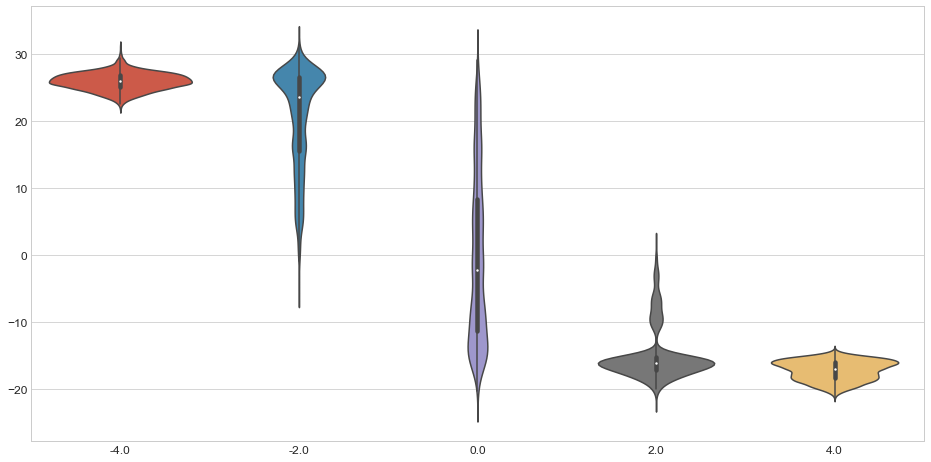

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


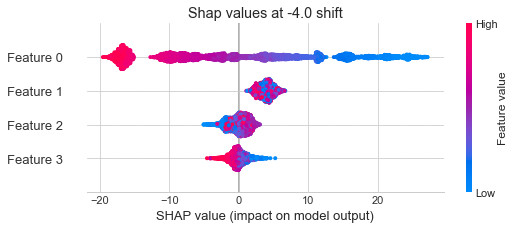

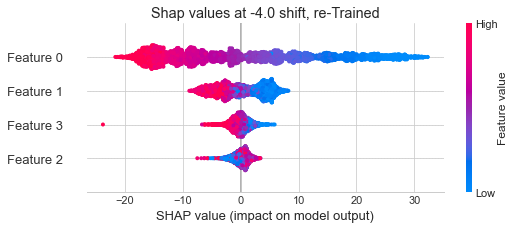

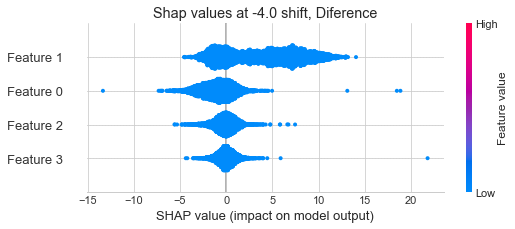

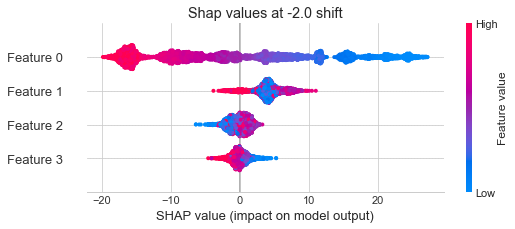

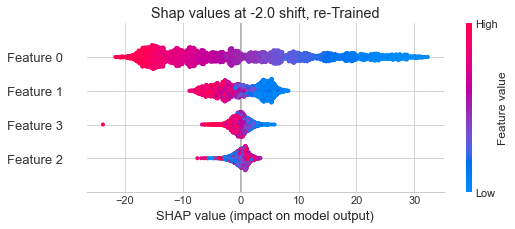

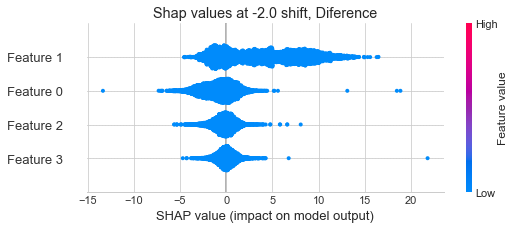

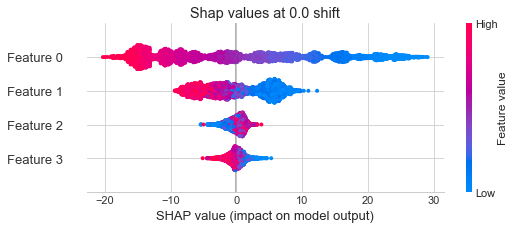

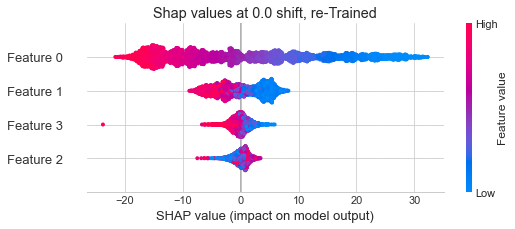

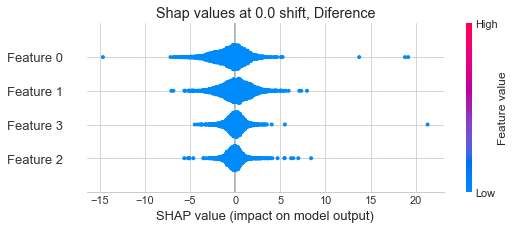

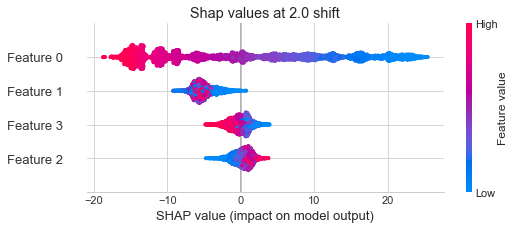

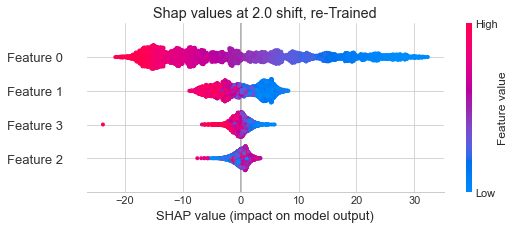

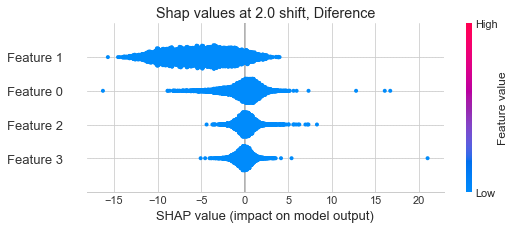

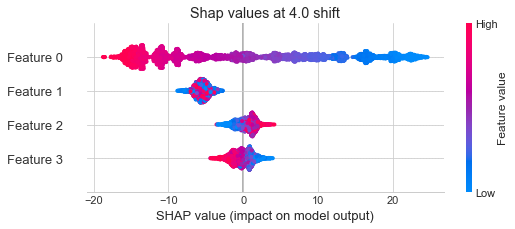

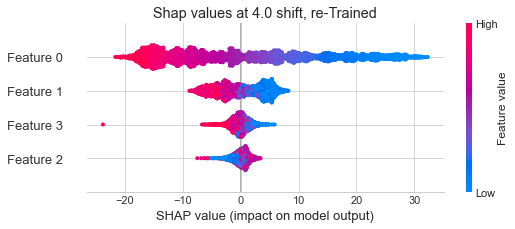

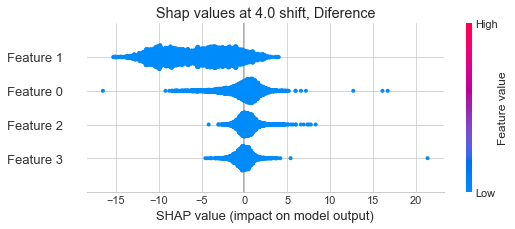

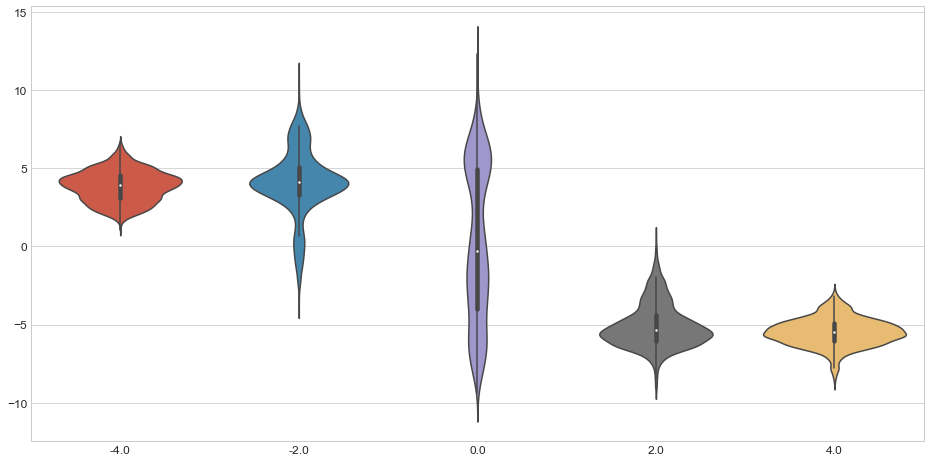

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


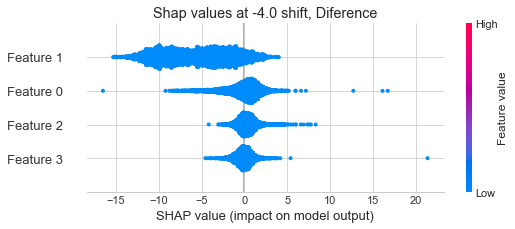

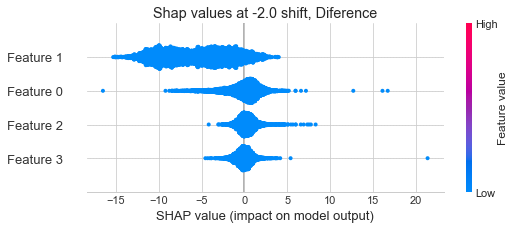

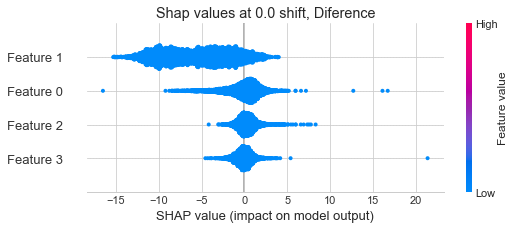

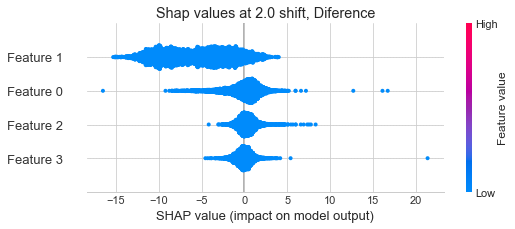

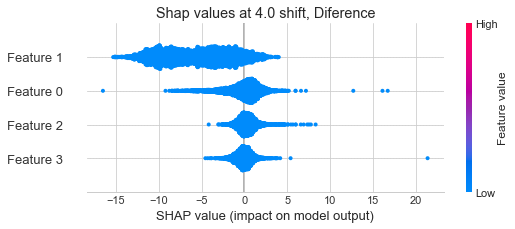

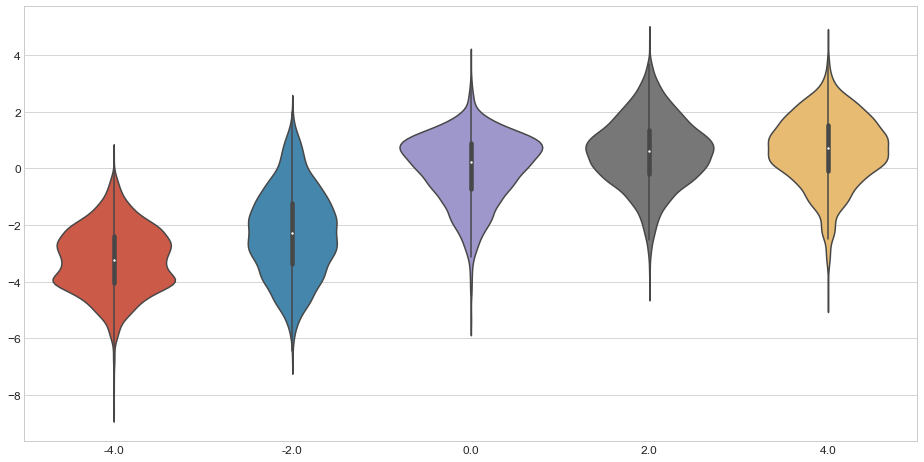

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


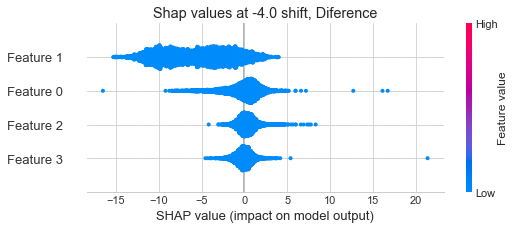

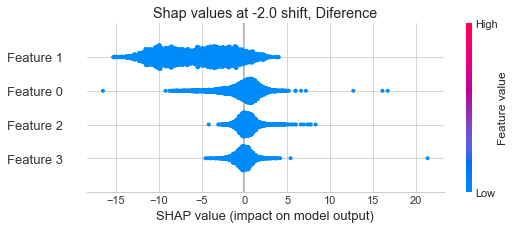

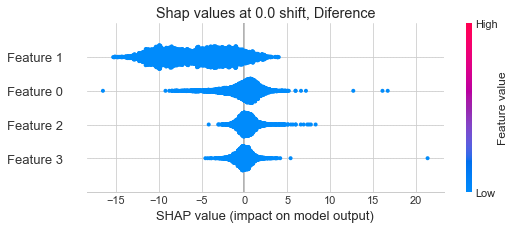

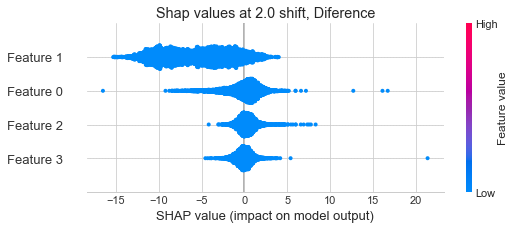

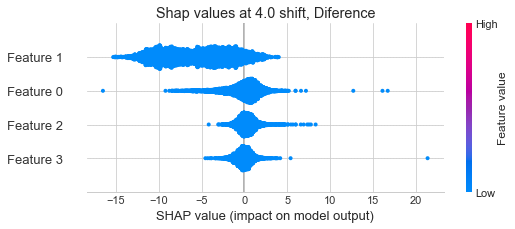

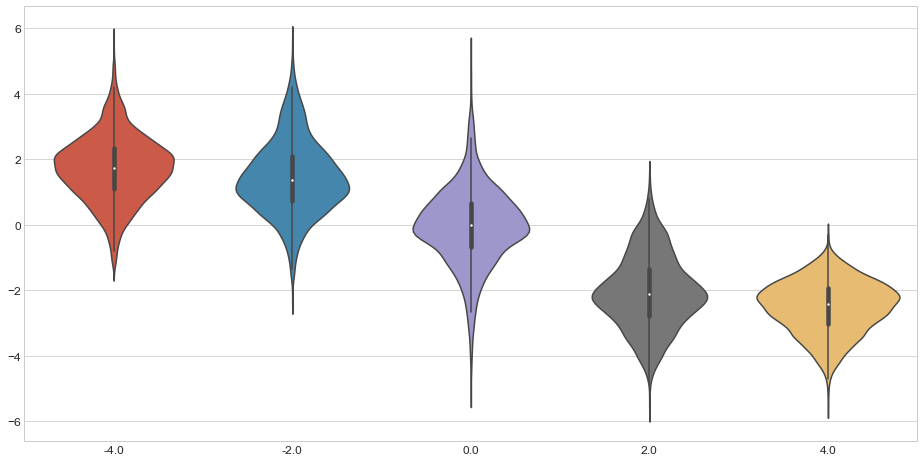

In [17]:
for dataset in dataset_classes:
    # Initialise the scaler
    standard_scaler = StandardScaler()

    # Load the dataset and split it
    X_train, X_test, y_train, y_test = dataset().split(test_size=0.5, random_seed=4242)

    # Scale the dataset
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test)

    # Initialise the shifter
    shifter = DistributionShift()
    shifter.fit(X_train)

    # Fit the regressor
    regressor = XGBRegressor()
    regressor.fit(X_train, y_train)
    explainer = shap.Explainer(regressor)

    # xx = np.arange(-10, 11, 1.0)
    xx = np.arange(-4, 6, 2.0)
    num_rows = X_train.shape[1] // 3
    print(X_train.shape)
    if X_train.shape[1] % 3 > 0:
        num_rows += 1

    for idx, col in enumerate(trange(X_train.shape[1])):

        shaps = defaultdict(list)
        true = defaultdict(list)
        for std in xx:
            
            # Shifts
            shifter.set_params(param=std, cols=[col])
            new_X_test = shifter.transform(X_test)
            
            # Explain in shift
            shaps[std] = explainer(new_X_test).values[:, idx]
            
            # Beeswarm plots of the shifted explanations
            if idx <2:
                shap_values = explainer(new_X_test)
                plt.figure()
                plt.title('Shap values at {} shift'.format(std))
                shap.plots.beeswarm(shap_values)
                plt.show()
            
            # Train and Explain
            model_test = XGBRegressor()
            model_test.fit(new_X_test,y_test)
            explainer_test = shap.Explainer(model_test)
            # Explain in shift
            true[std] = explainer_test(new_X_test).values[:, idx]
            if idx <2:
                shap_values_test = explainer_test(new_X_test)
                plt.figure()
                plt.title('Shap values at {} shift, re-Trained'.format(std))
                shap.plots.beeswarm(shap_values_test)
                plt.show()
                
            shap_values_diff = shap_values - shap_values_test
            
            plt.figure()
            plt.title('Shap values at {} shift, Diference'.format(std))
            shap.plots.beeswarm(shap_values_diff)
            plt.show()

            # Plotting
            #fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            #fig.subplots_adjust(wspace=1)

            #fig.suptitle("Identifying the")
            ### Figure Shift
            #ax1 = shap.plots.beeswarm(shap_values, show=False)
            
            ### Figure re-Trained
            #ax2 = shap.plots.beeswarm(shap_values, show=False)
            
                ### Figure Diff
            #ax3 = shap.plots.beeswarm(shap_values, show=False)
            
            #plt.savefig("experiments/xai/shap_comparison.eps",format='eps')
            #plt.show()
            


            
            
        shaps = pd.DataFrame(shaps)
        plt.figure()
        sns.violinplot(data=shaps)
        plt.show()


In [7]:
pd.DataFrame(shap_values.values).describe()


,0,1,2,3
count,4793.000000,4793.000000,4793.000000,4793.000000
mean,-0.202115,-5.461193,0.395385,-0.118927
std,12.426553,0.902058,1.183867,1.278436
min,-18.756107,-8.805140,-3.561560,-4.389179
25%,-11.499907,-6.051772,-0.465580,-1.078467
50%,-1.405575,-5.478971,0.601718,-0.089377
75%,10.059356,-4.888183,1.296310,0.824822
max,24.679476,-2.721617,4.185230,3.969699


In [8]:
pd.DataFrame(shap_values_diff.values).describe()

,0,1,2,3
count,4793.000000,4793.000000,4793.000000,4793.000000
mean,-0.120488,-5.498799,0.300827,-0.068390
std,2.002751,4.026490,1.006090,0.943466
min,-16.478851,-15.285002,-4.164462,-4.550305
25%,-0.939222,-8.940450,-0.323059,-0.595313
50%,0.255394,-5.297616,0.239658,-0.054351
75%,1.097357,-2.175167,0.824541,0.460648
max,16.674278,3.993325,8.281970,21.315916


In [9]:
np.arange(-6, 8, 2.0)

array([-6., -4., -2.,  0.,  2.,  4.,  6.])

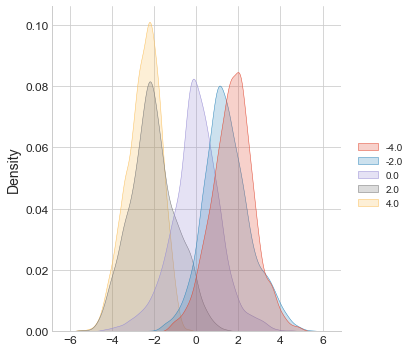

In [10]:
sns.displot(shaps,kind="kde", fill=True)

In [11]:
shaps.describe()

,-4.0,-2.0,0.0,2.0,4.0
count,4793.000000,4793.000000,4793.000000,4793.000000,4793.000000
mean,1.727386,1.450882,-0.032572,-2.054859,-2.510907
std,1.002194,1.126948,1.178020,1.110537,0.801646
min,-1.334847,-2.303258,-5.135789,-5.602375,-5.602375
25%,1.091110,0.724594,-0.664490,-2.786739,-3.040074
50%,1.743204,1.359163,-0.019341,-2.123869,-2.434340
75%,2.349560,2.113835,0.668479,-1.348010,-1.932011
max,5.627212,5.654038,5.284210,1.541088,-0.257697


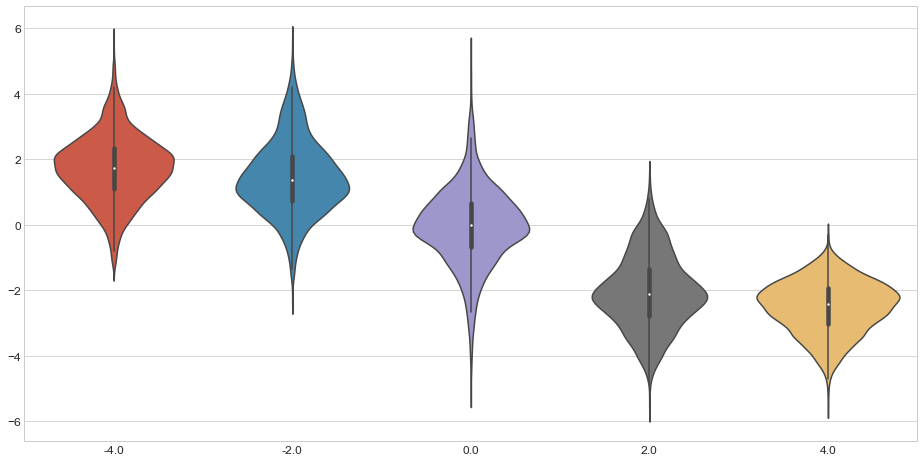

In [12]:
plt.figure()
sns.violinplot(data = shaps)
plt.show()

In [13]:
kk

NameError: name 'kk' is not defined

In [ ]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Number of standard deviations shifted")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [ ]:
def monitoring_plot(dataset, base_regressor: type, **kwargs):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X_train, X_test, y_train, y_test = dataset().split(
            test_size=0.3, random_seed=4242
        )

        # Scale the dataset
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test)

        # Initialise the shifter
        shifter = DistributionShift()
        shifter.fit(X_train)

        # Fit the regressor
        regressor = Boot(base_regressor(**kwargs))
        regressor.fit(X_train, y_train, n_boots=10)

        xx = np.arange(-10, 11, 1.0)
        num_rows = X_train.shape[1] // 3
        print(X_train.shape)
        if X_train.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )
        results_table = []
        unc_res = []
        ks_res = []
        psi_res = []
        for idx, col in enumerate(trange(X_train.shape[1])):
            values = defaultdict(list)
            for std in xx:
                shifter.set_params(param=std, cols=[col])
                new_X_test = shifter.transform(X_test)

                predictions, intervals = regressor.predict(
                    new_X_test, uncertainty=0.05, n_boots=20
                )

                values["uncertainty"].append(np.mean(intervals[:, 1] - intervals[:, 0]))
                values["psi"].append(
                    sum(
                        psi(X_train[:, c], new_X_test[:, c])
                        for c in range(X_train.shape[1])
                    )
                )
                values["ks"].append(
                    sum(
                        ks_2samp(X_train[:, c], new_X_test[:, c]).statistic
                        for c in range(X_train.shape[1])
                    )
                )
                values["mse"].append(  # np.mean((predictions - y_test) ** 2)
                    mean_absolute_error(predictions, y_test)
                )

            # Normalise the values
            for name, vals in values.items():
                values[name] = standard_scaler.fit_transform(np.expand_dims(vals, -1))

            # for name, vals in values.items():
            #    if name !='mse':
            #        values[name] = values[name]-values['mse']
            # del values['mse']
            # for name, vals in values.items():
            #    print(name)
            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(
                        xx, vals, marker="x", label=f"{name} values"
                    )
                else:
                    axs[idx // 3, idx % 3].plot(xx, vals, marker="x")

            unc_res.append(
                np.round(
                    np.mean((values["uncertainty"] - values["mse"]) ** 2), decimals=2
                )
            )
            psi_res.append(
                np.round(np.mean((values["psi"] - values["mse"]) ** 2), decimals=2)
            )
            ks_res.append(
                np.round(np.mean((values["ks"] - values["mse"]) ** 2), decimals=2)
            )

        results_table = [
            ["Unc", np.mean(unc_res)],
            ["psi", np.mean(psi_res)],
            ["ks", np.mean(ks_res)],
        ]
        print("Average MSE between MSE and metrics")
        print(tabulate(results_table))

        fig.legend()
        plt.savefig("fig.png")
        plt.show()

In [ ]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, GammaRegressor)